In [15]:
import os
import json
from pathlib import Path
from functools import partial
from typing import List, Optional, Dict, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
import pyro.poutine as poutine

# for CI testing
smoke_test = ('CI' in os.environ)
# assert pyro.__version__.startswith('0.3.1')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

In [2]:
DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 2 to 233
Data columns (total 3 columns):
cont_africa    170 non-null int64
rugged         170 non-null float64
rgdppc_2000    170 non-null float64
dtypes: float64(2), int64(1)
memory usage: 5.3 KB


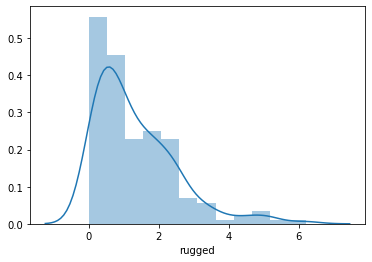

In [4]:
sns.distplot(df["rugged"])

In [5]:
class OLS(nn.Module):
    def __init__(self, num_params):
        super(OLS, self).__init__()
        self.linear = nn.Linear(num_params, 1)
        
    def forward(self, x):
        return self.linear(x)

In [6]:
model = OLS(3)

In [7]:
x_data = torch.rand(1000, 3)

In [8]:
y_data = x_data @ torch.tensor([[2],[-1], [1]], dtype=torch.float32) + torch.tensor(1e-2)

In [9]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(model.parameters(), lr=0.1)
num_iterations = 1000


def main():
    for j in range(num_iterations):
        # run the model forward on the data
        y_pred = model(x_data).squeeze(-1)
        # calculate the mse loss
        loss = loss_fn(y_pred, y_data)
        # initialize gradients to zero
        optim.zero_grad()
        # backpropagate
        loss.backward()
        # take a gradient step
        optim.step()
        if (j + 1) % 50 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))
    # Inspect learned parameters
    print("Learned parameters:")
    for name, param in model.named_parameters():
        print(name, param.data.numpy())

main()

/home/li/.virtualenvs/pp/lib/python3.6/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[iteration 0050] loss: 491375.2812
[iteration 0100] loss: 490273.1250
[iteration 0150] loss: 490260.5000
[iteration 0200] loss: 490260.5000
[iteration 0250] loss: 490260.5000
[iteration 0300] loss: 490260.5000
[iteration 0350] loss: 490260.4688
[iteration 0400] loss: 490260.4688
[iteration 0450] loss: 490260.4688
[iteration 0500] loss: 490260.4688
[iteration 0550] loss: 490260.4688
[iteration 0600] loss: 490260.4688
[iteration 0650] loss: 490260.4688
[iteration 0700] loss: 490260.4688
[iteration 0750] loss: 490260.4688
[iteration 0800] loss: 490260.4688
[iteration 0850] loss: 490260.4688
[iteration 0900] loss: 490260.4688
[iteration 0950] loss: 490260.4688
[iteration 1000] loss: 490260.4688
Learned parameters:
linear.weight [[-2.3307880e-08 -2.5608076e-08 -2.4100025e-08]]
linear.bias [0.9827749]


In [10]:
## Bayesian Regression

In [11]:
def model(x_data, y_data):
    # weight and bias priors
    w_prior = Normal(torch.zeros(1, 2), torch.ones(1, 2)).to_event(1)
    b_prior = Normal(torch.tensor([[8.]]), torch.tensor([[1000.]])).to_event(1)
    f_prior = Normal(0., 1.)
    priors = {'linear.weight': w_prior, 'linear.bias': b_prior, 'factor': f_prior}
    scale = pyro.sample("sigma", Uniform(0., 10.))
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", regression_model, priors)
    # sample a nn (which also samples w and b)
    lifted_reg_model = lifted_module()
    with pyro.plate("map", len(x_data)):
        # run the nn forward on data
        prediction_mean = lifted_reg_model(x_data).squeeze(-1)
        # condition on the observed data
        pyro.sample("obs",
                    Normal(prediction_mean, scale),
                    obs=y_data)
        return prediction_mean

In [12]:
from pyro.contrib.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model)

In [13]:
optim = Adam({"lr": 0.03})
svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=1000)

In [14]:
def train():
    pyro.clear_param_store()
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(x_data, y_data)
        if j % 100 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

train()

NameError: name 'regression_model' is not defined

In [ ]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

In [ ]:
get_marginal = lambda traces, sites:EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()

def summary(traces, sites):
    marginal = get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        marginal_site = pd.DataFrame(marginal[:, i]).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

def wrapped_model(x_data, y_data):
    pyro.sample("prediction", Delta(model(x_data, y_data)))

posterior = svi.run(x_data, y_data)


In [ ]:
# posterior predictive distribution we can get samples from
trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=1000)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"],
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

In [ ]:
# we need to prepend `module$$$` to all parameters of nn.Modules since
# that is how they are stored in the ParamStore
weight = get_marginal(posterior, ['module$$$linear.weight']).squeeze(1).squeeze(1)
factor = get_marginal(posterior, ['module$$$factor'])
gamma_within_africa = weight[:, 1] + factor.squeeze(1)
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness", fontsize=16)

In [ ]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [ ]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()

In [ ]:
# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [ ]:
# taken from PyTorch tutorials: https://pytorch.org/tutorials/beginner/nlp/advanced_tutorial.html
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        # tagset_size includes <START> and <STOP>
        self.tagset_size = len(tag_to_ix)

        # embedding matrix
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # project the output of the LSTM at each state into tag space. Input to CRF model.
        # fully connected layers, emission score per token
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters. Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        # this is NOT a right stochastic matrix whose row sums to 1, simply scores.

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _penalty(self, lda=1e-2, norm="l1"):
        w = self.transitions.detach()
        w[tag_to_ix[START_TAG], :] = 0
        w[:, tag_to_ix[STOP_TAG]] = 0
        
        if norm == "l1":
            return w.abs().sum() * lda
        elif norm == "l2":
            return torch.pow(w, 2).sum().sqrt() * lda
        else:
            return 0

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        # output [len(sentences), hidden_dim]
        lstm_feats = self.hidden2tag(lstm_out)
        # lstm_feats [len(sentence), len(tag_size)] aka emission score
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # feats in shape [len(sentences), len(tag_size)]
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        # insert corresponding index of START_TAG
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            # feat in [hidden_size], emission score from LSTM
            score += self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score += self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        # total of emission score and transition score, given the sequence and state transitions.
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best ptranath.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        # Lafferty et al. 2001
        # sentences are index-of-vocabulary, so are tags
        feats = self._get_lstm_features(sentence)
        # feats [len(sentence), len(tag_size)]
        # probability of the sequence given parameters (of BiLSTM and CRF)
        forward_score = self._forward_alg(feats)
        # if states (i.e. tags) are given, probability of sequence (i.e. pure emission scores)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score + self._penalty()

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [ ]:
def jsonl_to_bilou(iterable: List[Dict]) -> Tuple:
    for i in iterable:
        tokens = i["paragraphs"][0]["sentences"][0]["tokens"]
        words = [token["orth"] for token in tokens]
        entities = [token["ner"] for token in tokens]
        yield tuple([words, entities])

In [ ]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 10
HIDDEN_DIM = 8

# Make up some training data
# training_data = [(
#     "the wall street journal reported today that apple corporation made money".split(),
#     "B I I I O O O B I O O".split()
# ), (
#     "georgia tech is a university in georgia".split(),
#     "B I O O O O B".split()
# )]

with open(Path("./data/onto.jsonl/onto.train.json"), "r") as f:
    raw_train_json = json.load(f)
    training_data = list(jsonl_to_bilou(raw_train_json))[:50]

# with open(Path("./data/onto.jsonl/onto.development.json"), "r") as f:
#     raw_dev_json = json.load(f)
#     validation_data = list(jsonl_to_bilou(raw_dev_json))

word_to_ix = {}
tag_to_ix = {}
for sentence, tags in training_data:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

# for sentence, tags in validation_data:
#     for word in sentence:
#         if word not in word_to_ix:
#             word_to_ix[word] = len(word_to_ix)
#     for tag in tags:
#         if tag not in tag_to_ix:
#             tag_to_ix[tag] = len(tag_to_ix)

tag_to_ix[START_TAG] = len(tag_to_ix)
tag_to_ix[STOP_TAG] = len(tag_to_ix)


In [ ]:
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

In [ ]:
# Check predictions before training
with torch.no_grad():
    precheck_sent = prepare_sequence(training_data[0][0], word_to_ix)
    precheck_tags = torch.tensor([tag_to_ix[t] for t in training_data[0][1]], dtype=torch.long)
    print(model(precheck_sent))
    print(prepare_sequence(training_data[0][1], tag_to_ix))

In [ ]:
for epoch in range(30):
    for k, (sentence, tags) in enumerate(training_data):
        model.zero_grad()

        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        loss = model.neg_log_likelihood(sentence_in, targets)

        loss.backward()
        optimizer.step()

In [ ]:
tag_to_ix

In [ ]:
# Check predictions after training
with torch.no_grad():
    for i in range(len(training_data)):
        precheck_sent = prepare_sequence(training_data[i][0], word_to_ix)
        print(model(precheck_sent))
        print(prepare_sequence(training_data[i][1], tag_to_ix))

In [ ]:
penalty = model.transitions.data.numpy()

In [ ]:
from flair.embeddings import WordEmbeddings

In [ ]:
embedding = WordEmbeddings("glove")

In [ ]:
from flair.data import Sentence

In [ ]:
test = "we are travelling to Washington ."

In [ ]:
s = Sentence(test)

In [ ]:
s[-2].get_embedding()

In [ ]:
embedding.embed([s])

In [ ]:
s[-2].get_embedding().size()

In [ ]:
torch.cat([token.get_embedding().unsqueeze(0) for token in s], 0).size()

In [16]:
with open("training.log", "r") as f:
    no_penalty_0 = f.readlines()

In [17]:
with open("training_1.log", "r") as f:
    no_penalty_1 = f.readlines()

In [18]:
with open("training_l1.log", "r") as f:
    l1_penalty_0 = f.readlines()

In [19]:
with open("training_l1_1.log", "r") as f:
    l1_penalty_1 = f.readlines()

In [20]:
with open("training_2.log", "r") as f:
    no_penalty_2 = f.readlines()

In [21]:
with open("training_l1_2.log", "r") as f:
    l1_penalty_2 = f.readlines()

In [22]:
with open("training_3.log", "r") as f:
    no_penalty_3 = f.readlines()

In [23]:
with open("training_l1_3.log", "r") as f:
    l1_penalty_3 = f.readlines()

In [24]:
with open("training_4.log", "r") as f:
    no_penalty_4 = f.readlines()

In [25]:
with open("training_l1_4.log", "r") as f:
    l1_penalty_4 = f.readlines()

In [26]:
with open("training_5.log", "r") as f:
    no_penalty_5 = f.readlines()

In [27]:
with open("training_l2_5.log", "r") as f:
    l2_penalty_5 = f.readlines()

In [28]:
with open("training_6.log", "r") as f:
    no_penalty_6 = f.readlines()

In [29]:
with open("training_l2_6.log", "r") as f:
    l2_penalty_6 = f.readlines()

In [30]:
with open("training_7.log", "r") as f:
    no_penalty_7 = f.readlines()

In [31]:
with open("training_l2_7.log", "r") as f:
    l2_penalty_7 = f.readlines()

In [32]:
with open("training_8.log", "r") as f:
    no_penalty_8 = f.readlines()

In [33]:
with open("training_l2_w_8.log", "r") as f:
    l2_penalty_w_8 = f.readlines()

In [34]:
with open("training_9.log", "r") as f:
    no_penalty_9 = f.readlines()

In [35]:
with open("training_l2_w_9.log", "r") as f:
    l2_penalty_w_9 = f.readlines()

In [50]:
with open("training_10.log", "r") as f:
    no_penalty_10 = f.readlines()

In [51]:
with open("training_l2_w_10.log", "r") as f:
    l2_penalty_w_10 = f.readlines()

In [36]:
def _get_scores(lines):
    _breaker = "MACRO_AVG: acc"
    CAP = False
    sep2 = " - "
    sep3 = ": "
    summary = {}
    for l in lines:
        if _breaker in l:
            CAP = True
            continue
        if CAP:
            try:
                sep1 = l.index("tp:")
            except ValueError:
                CAP = False
                continue
            l = l.strip()
            entity, rest = l[:sep1].strip(), l[sep1:]
            summary[entity] = dict([i.split(sep3) for i in rest.split(sep2)])

    return summary

In [52]:
p_objects = [i for i in locals() if "penalty" in i]

In [53]:
with_penalty = [i for i in p_objects if i.startswith("l") and "_penalty" in i]

In [54]:
without_penalty = [i for i in p_objects if "no_penalty" in i]

In [55]:
def assemble_results(penalty, no_penalty):
    p_lst = []
    no_p_lst = []

    for k, (p, no_p) in enumerate(zip(penalty, no_penalty)):
        
        p_df = _get_scores(eval(p))
        p_df = pd.DataFrame(p_df)
        p_df["EXPERIMENT"] = k
        p_df["PENALTY"] = True
        p_lst.append(p_df)
        
        df = _get_scores(eval(no_p))
        df = pd.DataFrame(df)
        df["EXPERIMENT"] = k
        df["PENALTY"] = False
        no_p_lst.append(df)

    rv = pd.concat(p_lst + no_p_lst)
    rv = rv.drop(rv.index.difference(["f1-score"]), axis=0).reset_index(drop=True)
    return rv

In [56]:
with_penalty

['l1_penalty_0',
 'l1_penalty_1',
 'l1_penalty_2',
 'l1_penalty_3',
 'l1_penalty_4',
 'l2_penalty_5',
 'l2_penalty_6',
 'l2_penalty_7',
 'l2_penalty_w_8',
 'l2_penalty_w_9',
 'l2_penalty_w_10']

In [57]:
without_penalty

['no_penalty_0',
 'no_penalty_1',
 'no_penalty_2',
 'no_penalty_3',
 'no_penalty_4',
 'no_penalty_5',
 'no_penalty_6',
 'no_penalty_7',
 'no_penalty_8',
 'no_penalty_9',
 'no_penalty_10']

In [58]:
assm_df = assemble_results(with_penalty, without_penalty)

In [59]:
assm_df.loc[assm_df["EXPERIMENT"] >= 6]

,CARDINAL,DATE,EVENT,FAC,GPE,LANGUAGE,LAW,LOC,MONEY,NORP,ORDINAL,ORG,PERCENT,PERSON,PRODUCT,QUANTITY,TIME,WORK_OF_ART,EXPERIMENT,PENALTY
6,0.5827,0.6599,0.0000,0.1900,0.7805,0.0000,0.0400,0.3387,0.7088,0.7436,0.5897,0.6571,0.6445,0.7615,0.1986,0.0693,0.2037,0.1606,6,True
7,0.5813,0.6795,0.0000,0.3231,0.7719,0.0000,0.0000,0.1208,0.6104,0.7239,0.5459,0.6324,0.6637,0.7736,0.0000,0.2017,0.2787,0.0960,7,True
8,0.5282,0.6220,0.2087,0.2500,0.7851,0.0000,0.2222,0.4158,0.6708,0.7842,0.5915,0.6346,0.6254,0.7973,0.2131,0.2470,0.3100,0.2803,8,True
9,0.6201,0.6892,0.2295,0.2832,0.7800,0.3226,0.0384,0.3561,0.7325,0.7690,0.5579,0.6158,0.7059,0.7565,0.1449,0.3832,0.3029,0.1530,9,True
10,0.5860,0.6693,0.1222,0.1932,0.7898,0.3572,0.0000,0.2869,0.4765,0.7451,0.5885,0.6374,0.7205,0.7729,0.1887,0.4674,0.3158,0.2384,10,True
17,0.6010,0.6693,0.0000,0.1947,0.7843,0.0000,0.0392,0.3632,0.6936,0.7519,0.5721,0.6438,0.6531,0.7890,0.1875,0.0117,0.2136,0.1918,6,False
18,0.5585,0.6625,0.0000,0.2782,0.7458,0.0000,0.0000,0.0772,0.6213,0.7134,0.4767,0.5928,0.6543,0.7560,0.0000,0.1389,0.2135,0.0000,7,False
19,0.5014,0.6219,0.0223,0.0382,0.7608,0.0000,0.0471,0.3225,0.6577,0.7796,0.5820,0.6319,0.6271,0.7834,0.0521,0.1407,0.0655,0.2074,8,False
20,0.6310,0.6906,0.2147,0.1762,0.7776,0.0000,0.0000,0.2571,0.7227,0.7828,0.5048,0.6393,0.6998,0.7627,0.0210,0.2960,0.2320,0.1185,9,False
21,0.5610,0.6756,0.0649,0.0459,0.7726,0.0000,0.0000,0.1325,0.5019,0.7508,0.5075,0.6288,0.7011,0.7894,0.0000,0.1730,0.1484,0.1308,10,False


In [63]:
with open("corpus_l2_w_10.log") as f:
    with open("corpus_10.log") as w:
        z = f.read()
        assert z == w.read()
        print(z)

{
    "TRAIN": {
        "dataset": "TRAIN",
        "total_number_of_documents": 2316,
        "number_of_documents_per_class": {},
        "number_of_tokens_per_tag": {
            "O": 39039,
            "B-ORG": 514,
            "B-PERSON": 466,
            "I-PERSON": 331,
            "I-ORG": 643,
            "B-DATE": 366,
            "B-PERCENT": 71,
            "I-PERCENT": 116,
            "B-CARDINAL": 209,
            "I-CARDINAL": 72,
            "I-DATE": 399,
            "B-TIME": 35,
            "B-GPE": 470,
            "I-GPE": 133,
            "B-NORP": 185,
            "B-LOC": 46,
            "I-LOC": 59,
            "B-MONEY": 87,
            "I-MONEY": 132,
            "B-PRODUCT": 24,
            "B-LANGUAGE": 7,
            "B-QUANTITY": 21,
            "I-TIME": 20,
            "B-EVENT": 23,
            "I-EVENT": 54,
            "B-FAC": 20,
            "I-FAC": 31,
            "I-NORP": 15,
            "B-ORDINAL": 38,
            "I-PRODUCT": 13,
         